[View in Colaboratory](https://colab.research.google.com/github/ayshrwt/Planet-Understanding-the-amazon-from-space/blob/master/Planet_Understanding_the_amazon_from_space.ipynb)

In [0]:
!pip install fastai

In [2]:
!pip install scipy==1.0.0

In [3]:
!pip install pillow==4.1.1

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = 'data/planets/'

In [10]:
ls {PATH}

models/  test-jpg/  tmp/  train-jpg/  train_v2.csv


In [12]:
!pip install planet

    100% |████████████████████████████████| 40kB 3.4MB/s 
    100% |████████████████████████████████| 71kB 7.1MB/s 
  Running setup.py bdist_wheel for requests-futures ... - done
  Stored in directory: /content/.cache/pip/wheels/71/fb/7a/0caacf78e523a182dadd1d042792801cfd53f27c77b945b64a
Successfully built requests-futures


In [20]:
from google.colab import files
files.upload()

Saving planet.py to planet.py


{'planet.py': b'from fastai.imports import *\r\nfrom fastai.transforms import *\r\nfrom fastai.dataset import *\r\nfrom sklearn.metrics import fbeta_score\r\nimport warnings\r\n\r\ndef f2(preds, targs, start=0.17, end=0.24, step=0.01):\r\n    with warnings.catch_warnings():\r\n        warnings.simplefilter("ignore")\r\n        return max([fbeta_score(targs, (preds>th), 2, average=\'samples\')\r\n                    for th in np.arange(start,end,step)])\r\n\r\ndef opt_th(preds, targs, start=0.17, end=0.24, step=0.01):\r\n    ths = np.arange(start,end,step)\r\n    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average=\'samples\')\r\n                for th in ths])\r\n    return ths[idx]\r\n\r\ndef get_data(path, tfms,bs,  n, cv_idx):\r\n    val_idxs = get_cv_idxs(n, cv_idx)\r\n    return ImageClassifierData.from_csv(path, \'train-jpg\', f\'{path}train_v2.csv\', bs, tfms,\r\n                                 suffix=\'.jpg\', val_idxs=val_idxs, test_name=\'test-jpg\')\r\n\r\ndef get_da

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

In [0]:
metrics=[f2]
f_model = resnet34

In [0]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [0]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [0]:
data = get_data(256)

In [0]:
x, y = next(iter(data.val_dl))

In [28]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [29]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

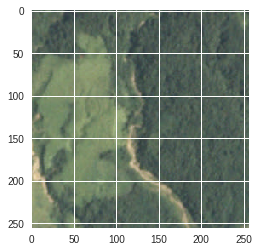

In [30]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [0]:
sz=64

In [0]:
data = get_data(sz)

In [33]:
data = data.resize(int(sz*1.3), 'tmp')

In [34]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 47498091.54it/s]


epoch      trn_loss   val_loss   f2         
    0      0.232113   0.320665   0.832132  



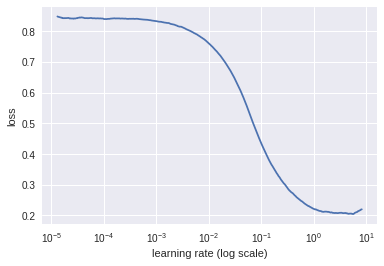

In [35]:
lrf=learn.lr_find()
learn.sched.plot()

In [0]:
lr = 0.2

In [37]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.149594   0.134388   0.883067  
 25%|██▌       | 128/506 [04:06<12:07,  1.92s/it, loss=0.15] 

    1      0.14236    0.128937   0.888664  
 51%|█████     | 257/506 [08:34<08:18,  2.00s/it, loss=0.137]

    2      0.137288   0.126986   0.890594  
 66%|██████▌   | 332/506 [10:35<05:33,  1.92s/it, loss=0.139]

    3      0.137057   0.126823   0.887582  
 74%|███████▍  | 376/506 [11:59<04:08,  1.91s/it, loss=0.137]

    4      0.134933   0.124519   0.892655  
 79%|███████▉  | 401/506 [13:29<03:32,  2.02s/it, loss=0.131]

    5      0.130551   0.123025   0.893624  
 82%|████████▏ | 416/506 [13:46<02:58,  1.99s/it, loss=0.132]

    6      0.13189    0.122894   0.892911  



[array([0.12289]), 0.8929113198897565]

In [0]:
lrs = np.array([lr/9,lr/3,lr])

In [39]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.119756   0.109796   0.907623  
 25%|██▌       | 128/506 [13:01<38:28,  6.11s/it, loss=0.125]

    1      0.11459    0.106358   0.909022  
 51%|█████     | 257/506 [26:17<25:28,  6.14s/it, loss=0.111]

    2      0.10749    0.102053   0.914157  
 66%|██████▌   | 332/506 [34:39<18:09,  6.26s/it, loss=0.113]

    3      0.113219   0.10508    0.91229   
 74%|███████▍  | 375/506 [38:45<13:32,  6.20s/it, loss=0.109]

    4      0.108178   0.100165   0.915976  
 79%|███████▉  | 400/506 [41:30<10:59,  6.23s/it, loss=0.104]

    5      0.103622   0.097909   0.918283  
 82%|████████▏ | 414/506 [42:42<09:29,  6.19s/it, loss=0.101]

    6      0.097369   0.097323   0.918155  



[array([0.09732]), 0.9181546777951566]